In [1]:
import sys
import os
import numpy as np
import numpy.linalg as la

from ControlRF import GPController, ADPKernel, ADPRandomFeatures, ADKernel, ADRandomFeatures, VanillaKernel, VanillaRandomFeatures
from ControlRF.plots import *
from ControlRF.util import data_gen

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/core")

import core
from core.controllers import QPController
from core.dynamics import AffineQuadCLF
from core.systems import InvertedPendulum, DoubleInvertedPendulum

In [2]:
def main_invp(plot_sim=True, plot_errorbars=True): #d=1
    system = InvertedPendulum(0.7,0.7)
    system_est = InvertedPendulum(0.50,0.5)
    lyap_est = AffineQuadCLF.build_care(system_est, Q=np.identity(2), R=np.identity(1))
    
    alpha = 1 / max(la.eigvals(lyap_est.P))
    
    # Nominal Controller Static Slacked
    controller = QPController(system_est, system.m)
    controller.add_static_cost(np.identity(1))
    controller.add_stability_constraint(lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 1e3)
    
    x_0 = np.array([2, 0.1])
    xs, ys, zs = data_gen(system, controller, lyap_est, x_0, 100, 1000)
    ad_rf = ADRandomFeatures(xs, ys, zs, rf_d=50)
    adp_rf = ADPRandomFeatures(xs, ys, zs, rf_d=50)
    ad_kernel =ADKernel(xs, ys, zs)
    adp_kernel = ADPKernel(xs, ys, zs)
    gps = [ad_kernel, ad_rf, adp_kernel, adp_rf]
    controllers = []
    x_0 = np.array([1, 0.1])

    for gp in gps:
        gp_controller = GPController(system_est, gp)
        gp_controller.add_static_cost(np.identity(1))
        gp_controller.add_stability_constraint(lyap_est, comp=alpha, slacked=True, beta = 1, coeff=1e5)
        controllers.append(gp_controller)
        print(f'training time for {gp.__name__}_gp is: {gp.training_time}')
        if plot_sim:
            plot_simulation(system, gp_controller, f'{gp.__name__}_controller', x_0, T=100, num_steps=1000)
            plot_closed_loop_errorbar(system, lyap_est, gp_controller, gp, x_0, cut_off=20) #cut_off=180 is good as well

    if plot_errorbars:
        plot_pred_errorbar(xs[300:350], ys[300:350], zs[300:350], gps)
        plot_pred_errorbar(xs[950:], ys[950:], zs[950:], gps)
        
        plot_all_closed_loop_errorbars(system, lyap_est, controllers, gps, x_0, cut_off=180)
    
        
   
        


In [3]:
def main_double_invp(plot=True):
    system = DoubleInvertedPendulum(0.25,0.25,.7,0.7)
    system_est = DoubleInvertedPendulum(0.5,0.5,0.5,0.5)
    Q , R = 10*np.identity(4), np.identity(2)
    q_d = np.array([-1, 0])
    #lyap_est = ??
        
    alpha = min(la.eigvalsh(Q)) / max(la.eigvalsh(lyap_est.P))
    
    # Nominal Controller Static Slacked
    # controller = QPController.build_care(system_est,Q ,R)
    controller = QPController(system, 2)
    controller.add_stability_constraint(lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 1e5)
    

    # lqr = LQRController.build(set_point, Q, R)
    # fb_lin = FBLinController(set_point, lqr)
    # qp.add_regularizer(fb_lin, 1)

training time for ad_kernel_gp is: 0.1365824129898101
training time for ad_rf_gp is: 0.0015983899938873947
training time for adp_kernel_gp is: 0.0941578820347786
training time for adp_rf_gp is: 0.0021527810022234917


/Users/kimia/Work/Sarah/control/random_features/ControlRF/plots.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


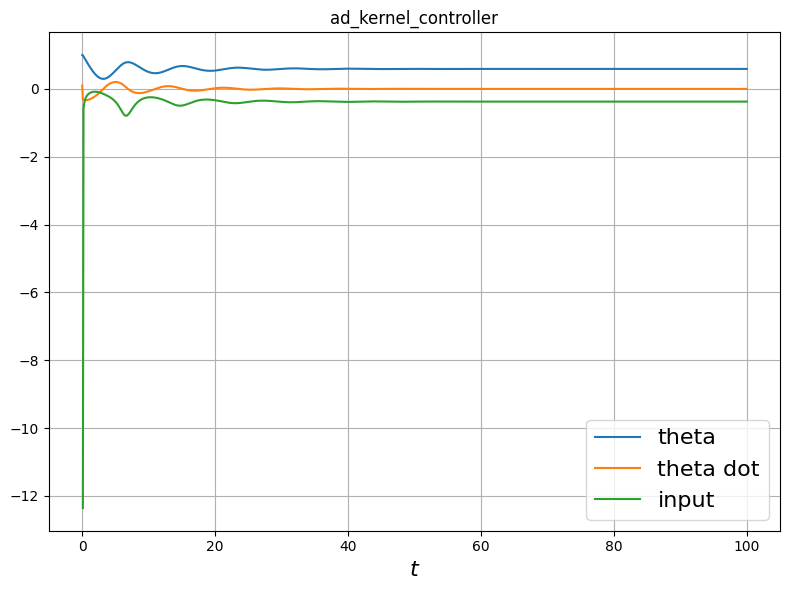

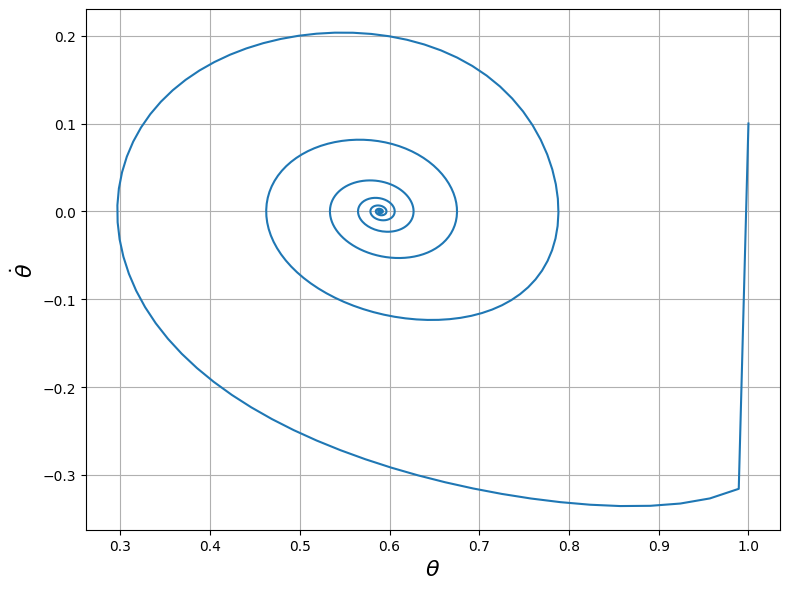

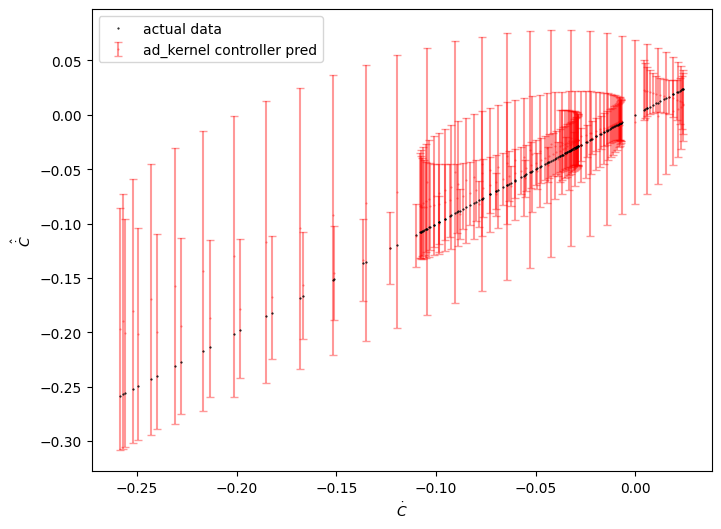

<Figure size 640x480 with 0 Axes>

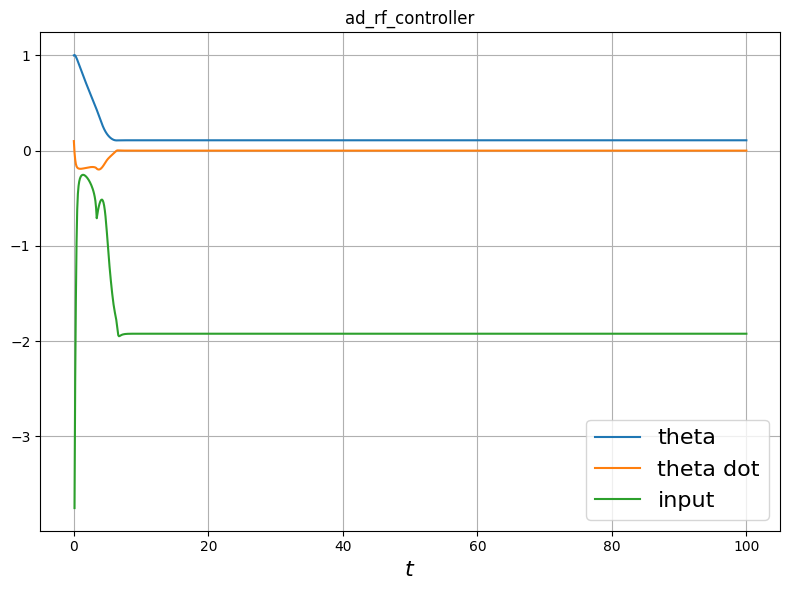

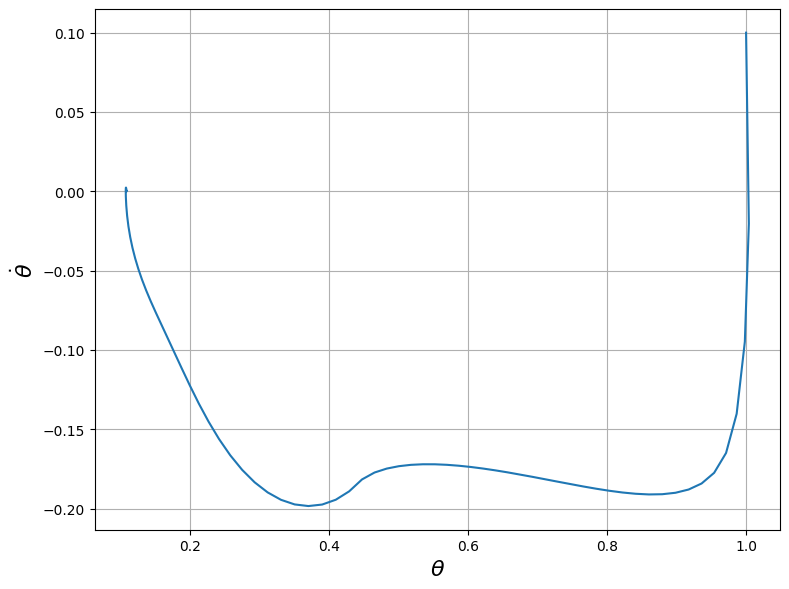

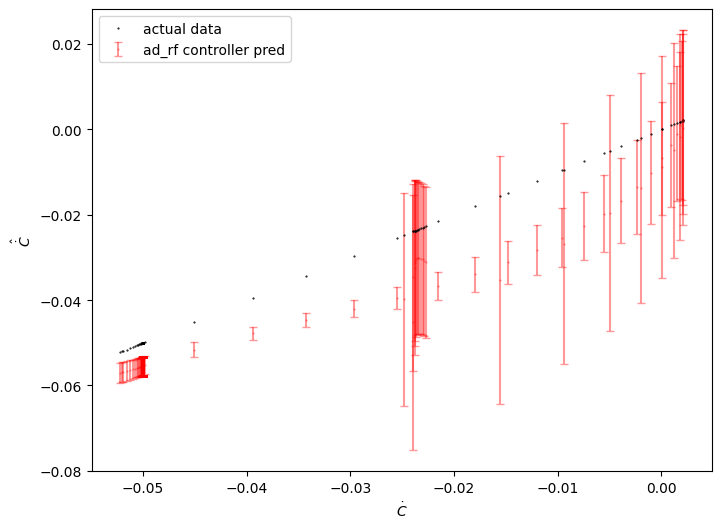

<Figure size 640x480 with 0 Axes>

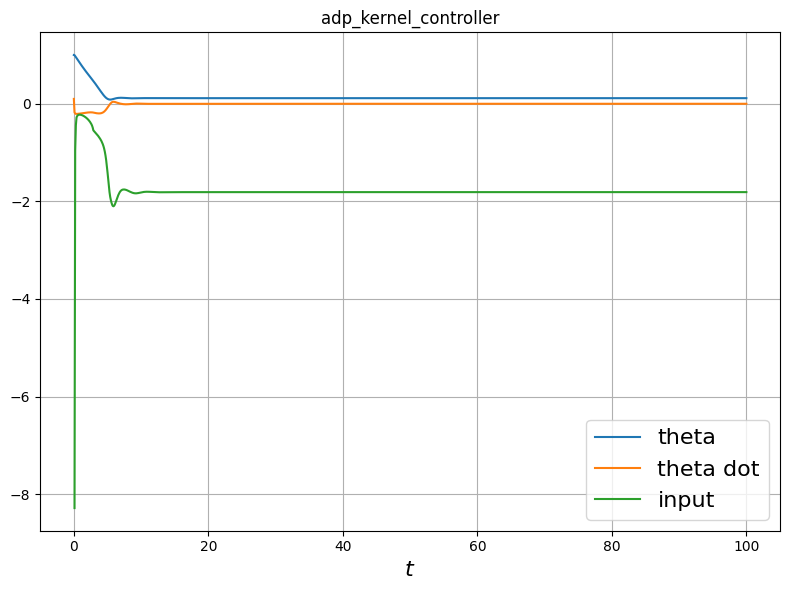

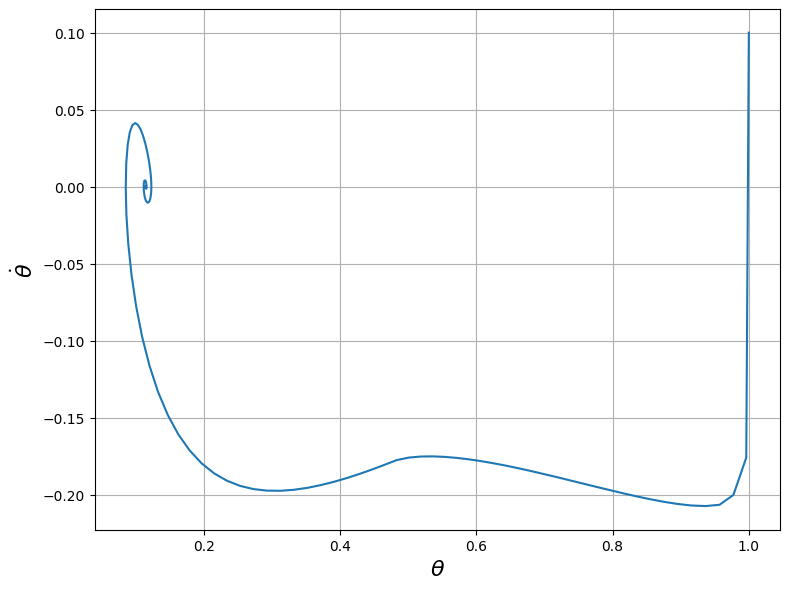

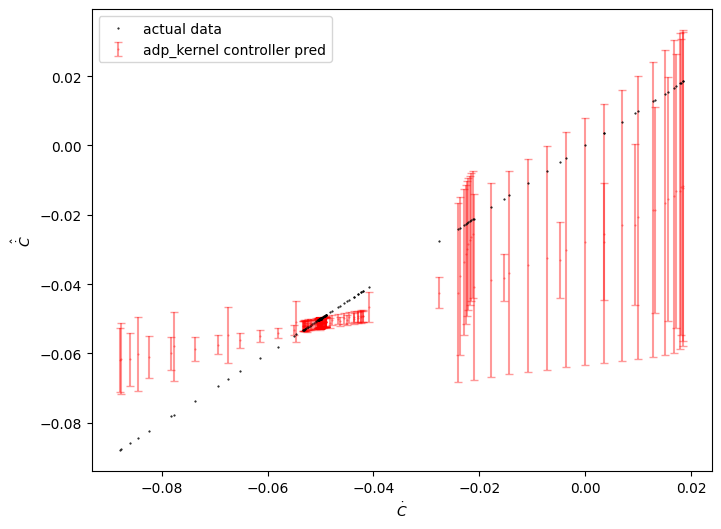

<Figure size 640x480 with 0 Axes>

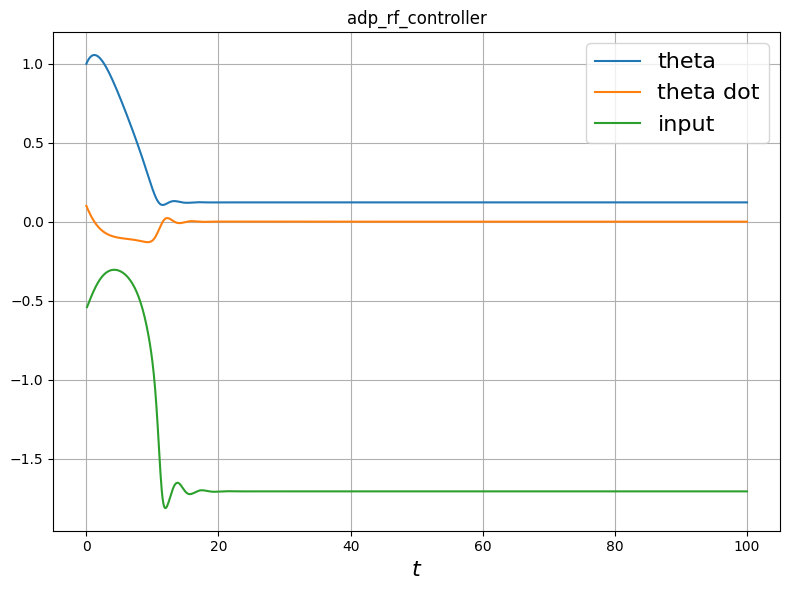

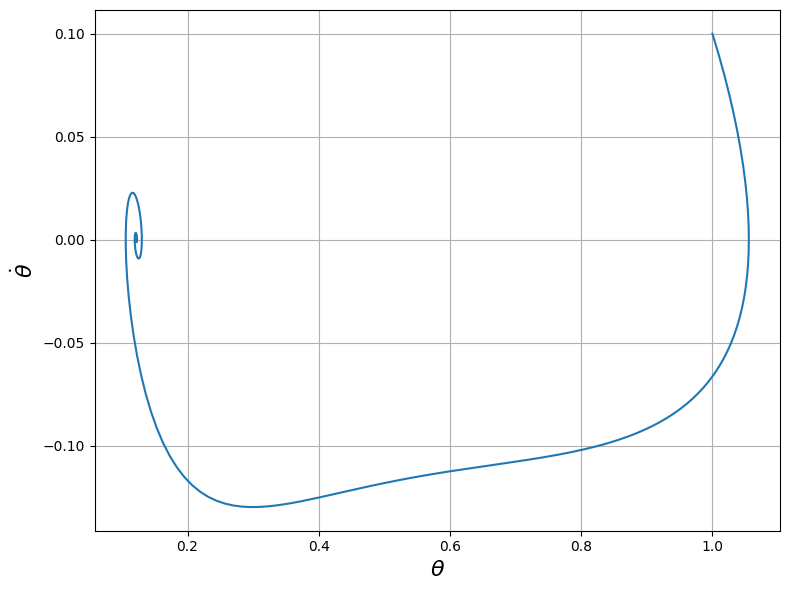

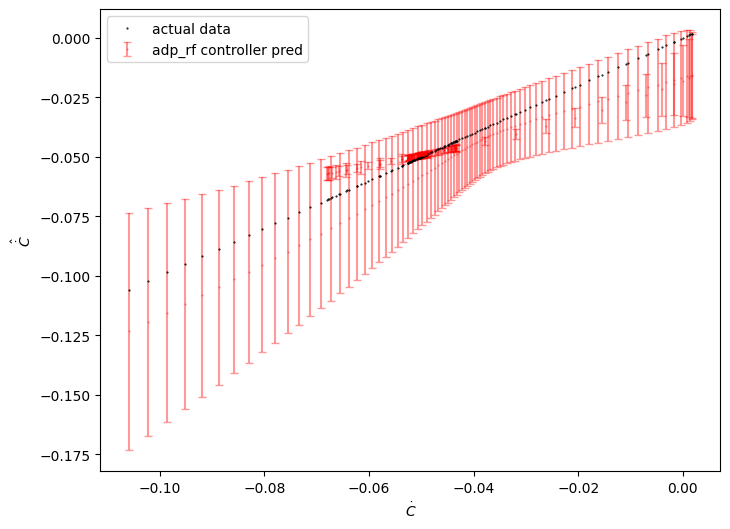

<Figure size 640x480 with 0 Axes>

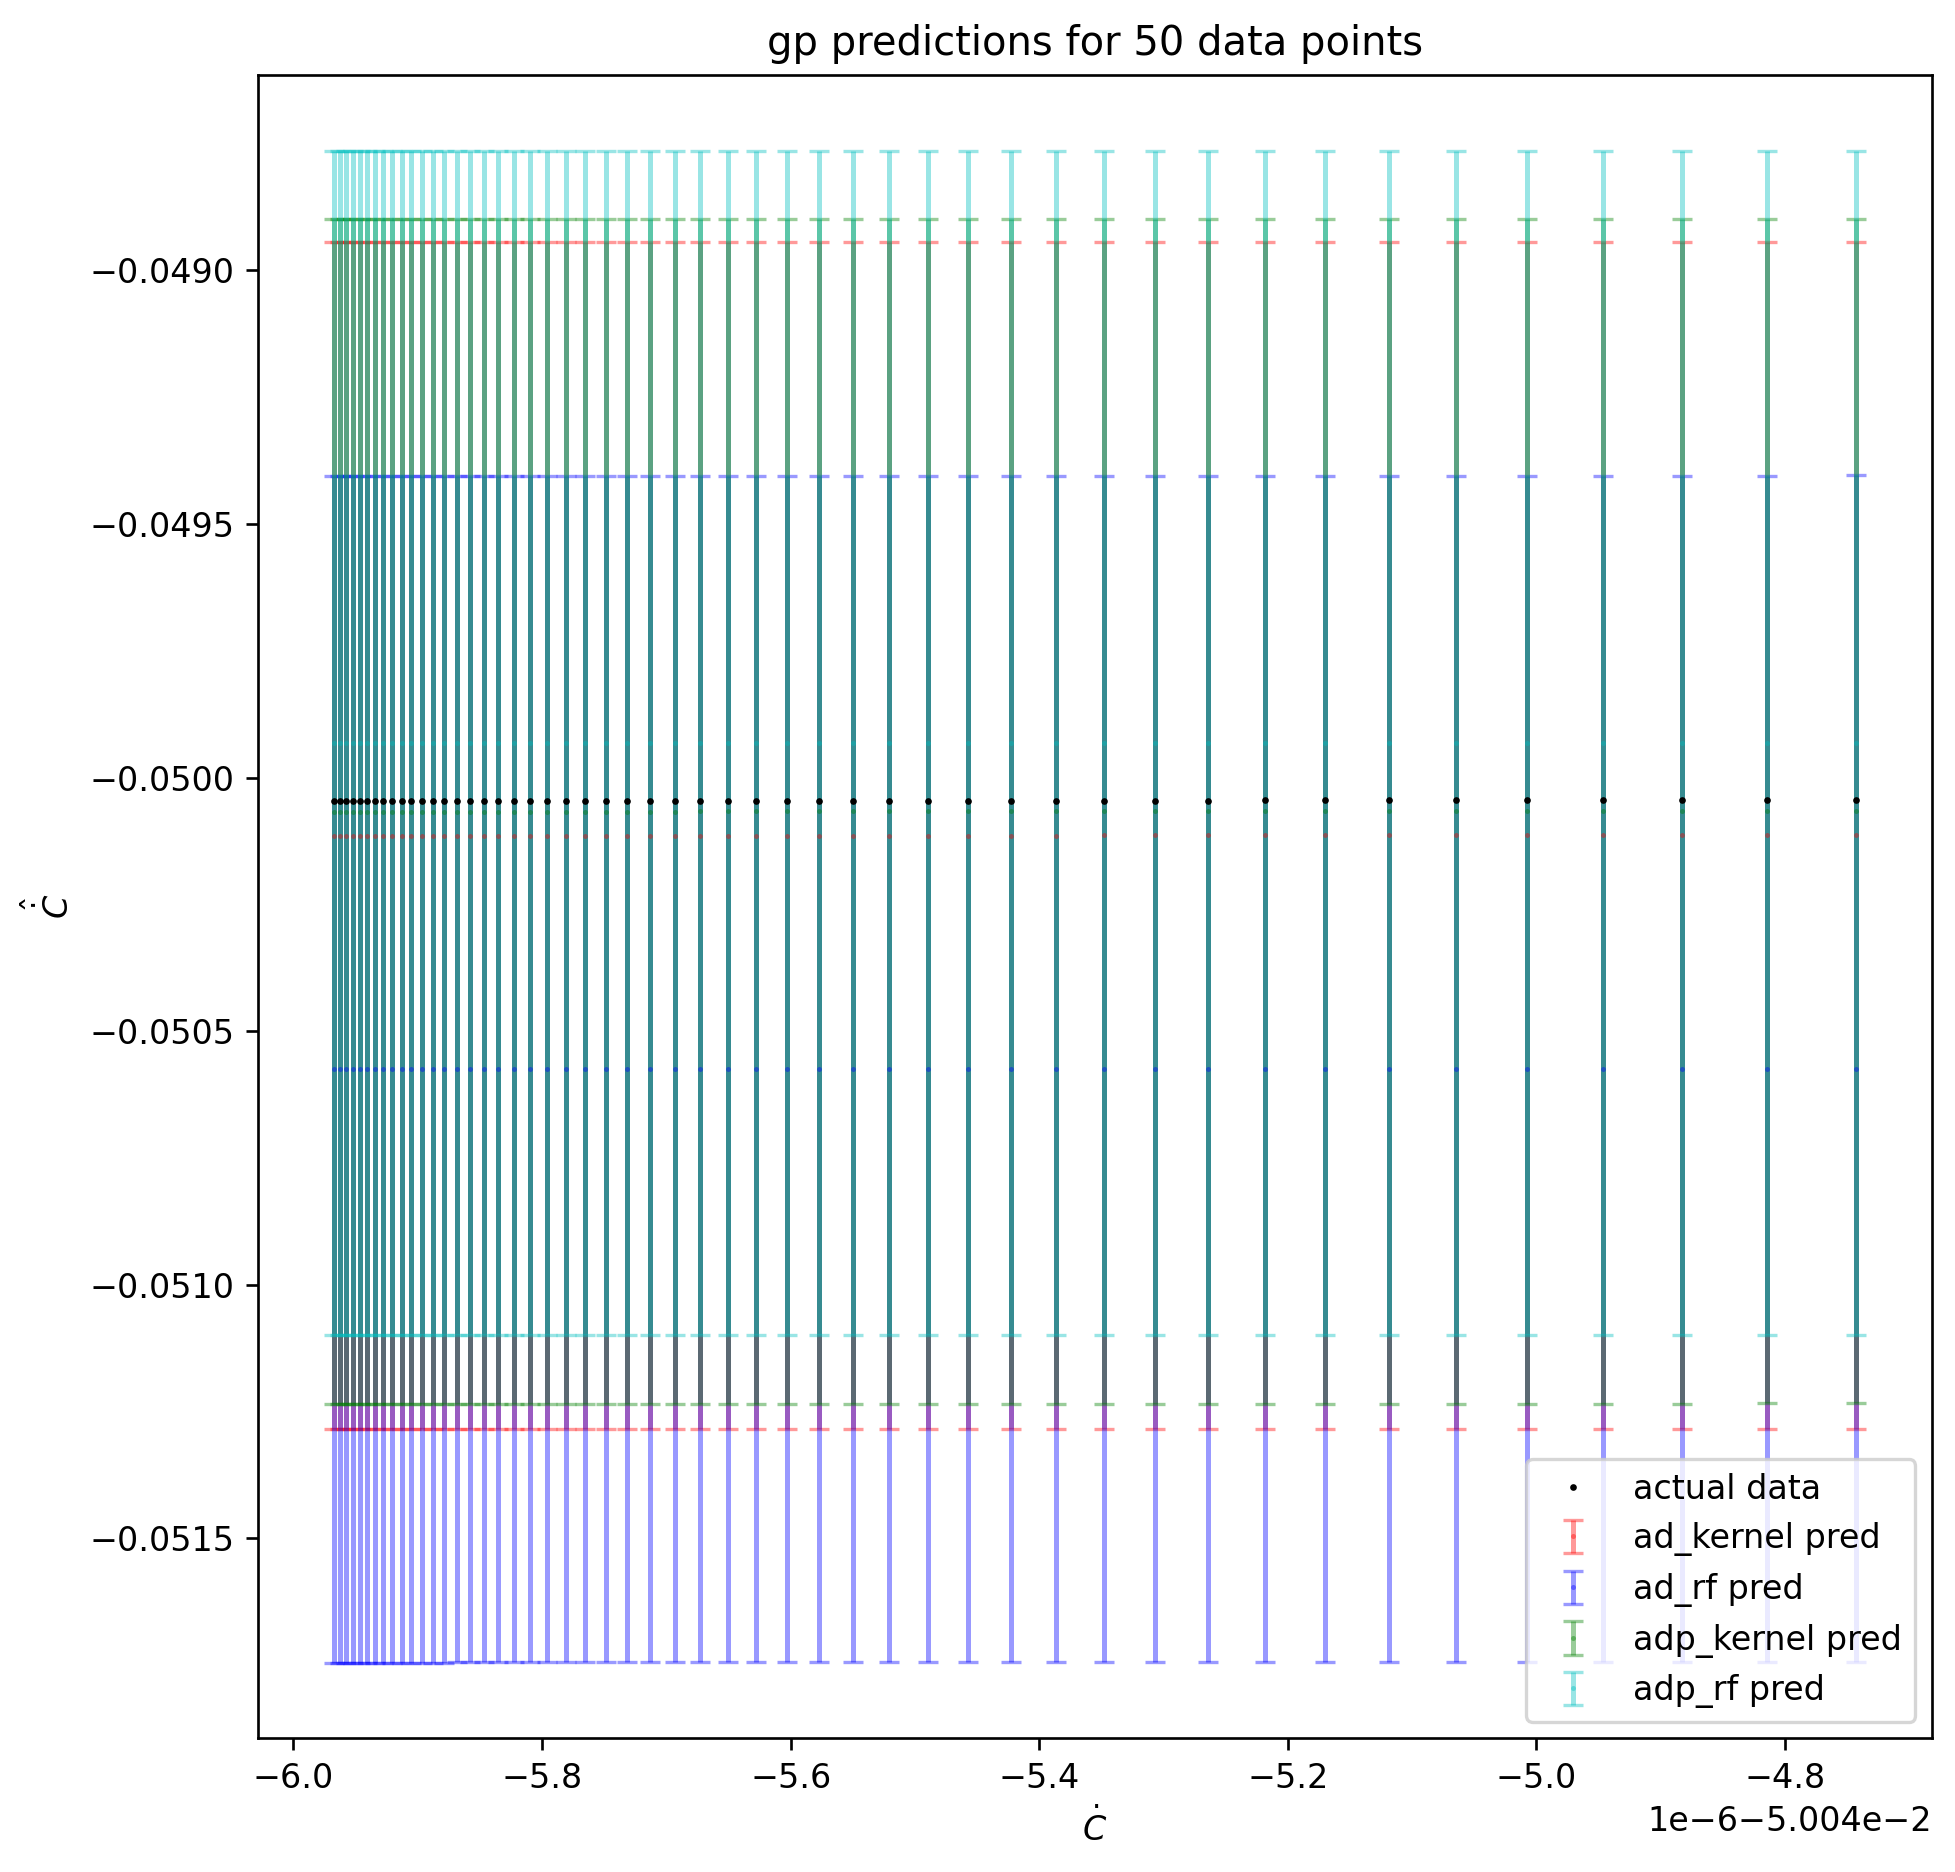

<Figure size 640x480 with 0 Axes>

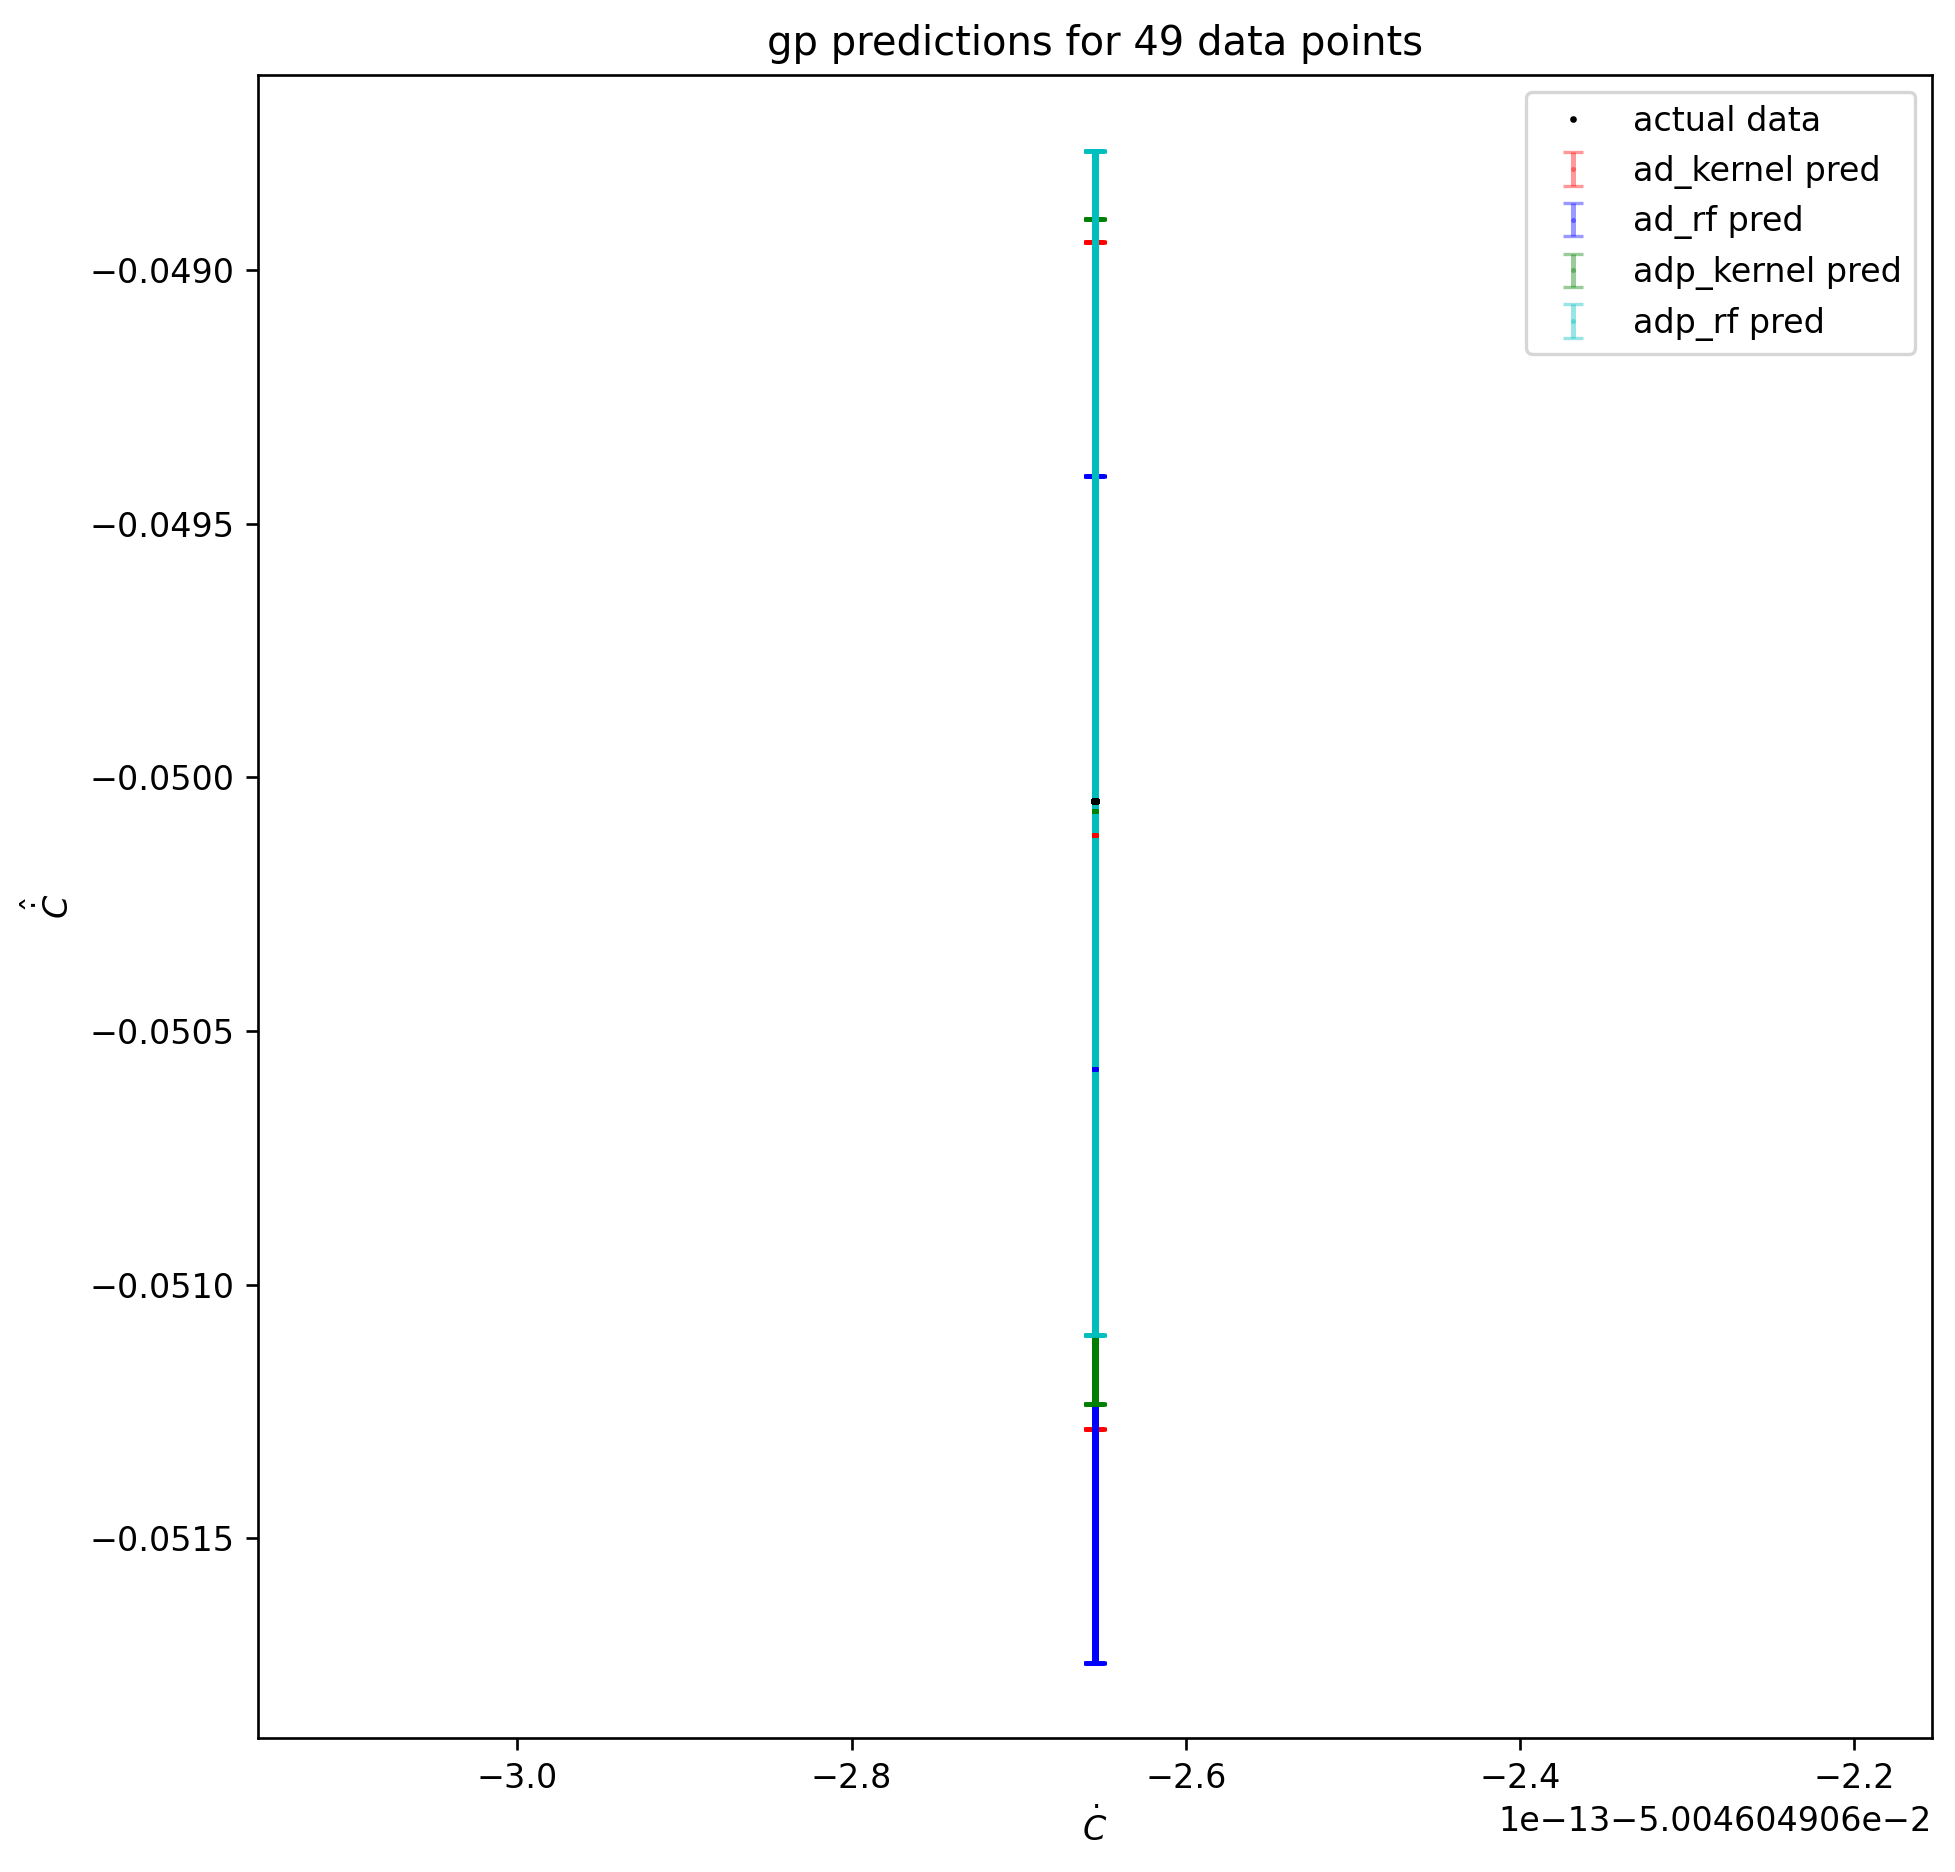

<Figure size 640x480 with 0 Axes>

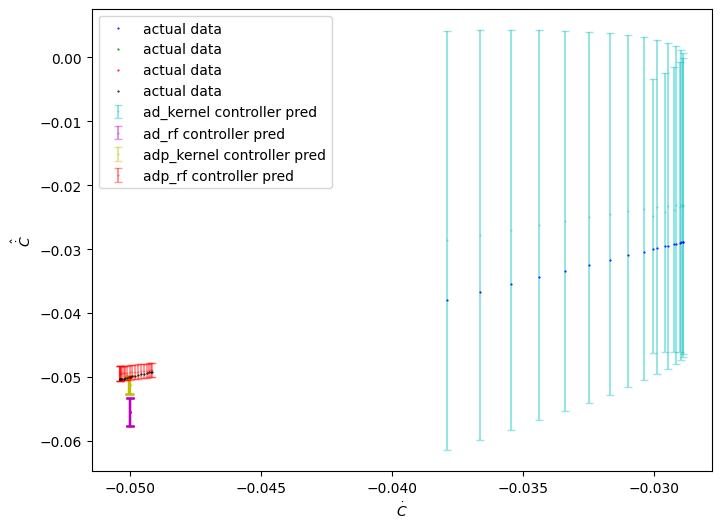

<Figure size 640x480 with 0 Axes>

In [4]:
main_invp()